# SDG Data analysis

## Data source
* https://sdgindex.org/
* https://data.worldbank.org/indicator/EN.ATM.CO2E.PC

In [1]:
import pandas as pd
import numpy as np
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

from fbprophet import Prophet

# Data Preparation

## SDG Index

In [2]:
sdg_index = pd.read_csv('../data/sdg_index.csv')
rank_df = sdg_index.sort_values('Global Index Rank')[['country', 'id', 'Global Index Score (0-100)', 'Global Index Rank']].dropna()
rank_df.head(5)

,country,id,Global Index Score (0-100),Global Index Rank
46,Denmark,DNK,85.2,1.0
166,Sweden,SWE,85.0,2.0
59,Finland,FIN,82.8,3.0
61,France,FRA,81.5,4.0
9,Austria,AUT,81.1,5.0


In [3]:
top_ranks = rank_df['country'].values.tolist()[:10]
top_ranks

['Denmark',
 'Sweden',
 'Finland',
 'France',
 'Austria',
 'Germany',
 'Czech Republic',
 'Norway',
 'Netherlands',
 'Estonia']

## CO2 Emissions

In [4]:
raw_e = pd.read_csv('../raw_data/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380/API_EN.ATM.CO2E.PC_DS2_en_csv_v2_10515380.csv', skiprows=3)
raw_e.head(1)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,Unnamed: 63
0,Aruba,ABW,CO2 emissions (metric tons per capita),EN.ATM.CO2E.PC,NaN,NaN,NaN,NaN,NaN,NaN,...,24.670529,24.505835,13.155542,8.351294,8.408363,NaN,NaN,NaN,NaN,NaN


In [5]:
def add_emission(row, raw_e_country):
    index = str(row['date'].year)
    value = raw_e_country.loc[index]
    return value

def create_df_per_country(raw_e, country_code):
    raw_e_country = raw_e[raw_e['Country Name'] == country_code].loc[:,'1960':'2014']
    raw_e_country = raw_e_country.T
    raw_e_country.columns = ['value']

    date_range = pd.date_range(start='1960-12-31', end='2014-12-31', freq='y')
    e = pd.DataFrame(date_range, columns=['date'])
    e['emissions'] = e.apply(lambda row: add_emission(row, raw_e_country), axis=1)
    e.set_index('date', inplace=True)
    return e

country_list = top_ranks
dfs = [{'country': country, 'df': create_df_per_country(raw_e, country)} for country in country_list]

## Visualization

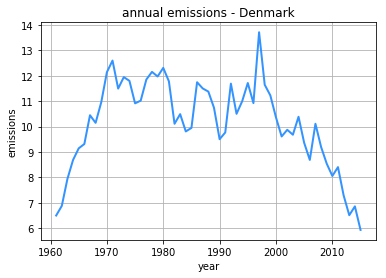

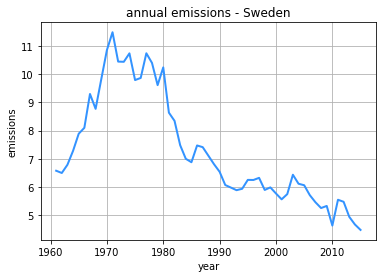

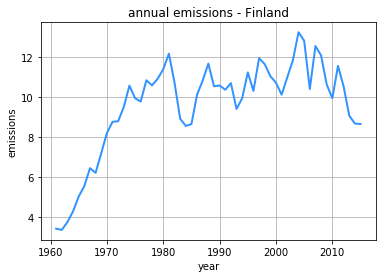

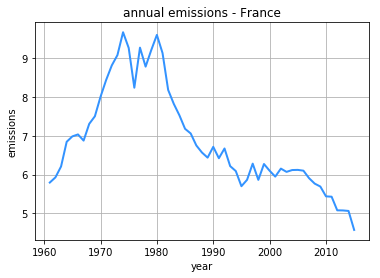

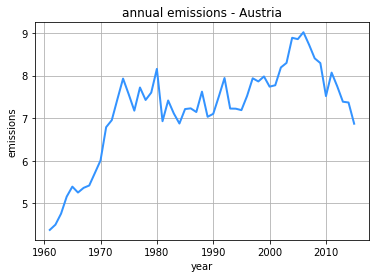

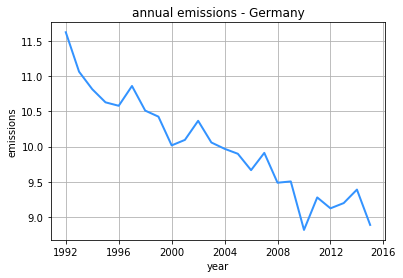

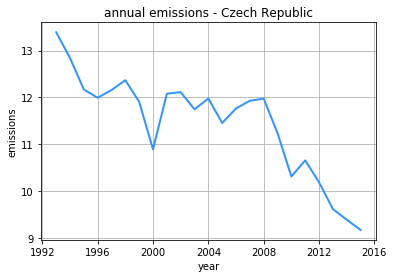

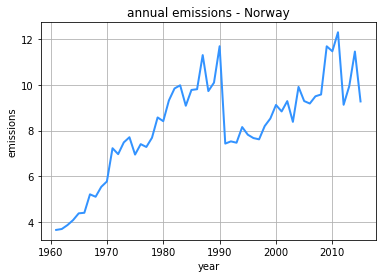

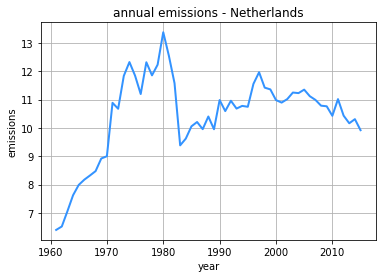

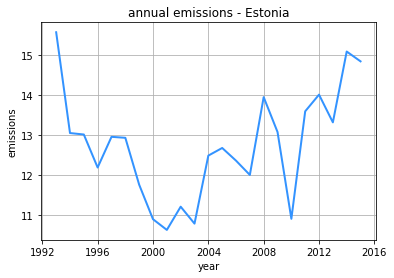

In [6]:
for df in dfs:
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(df['df'], color='#3393FF', linewidth=2)
    ax.set(xlabel='year', ylabel='emissions',
           title=f'annual emissions - {df["country"]}')
    ax.grid()

## Forecasting

Denmark


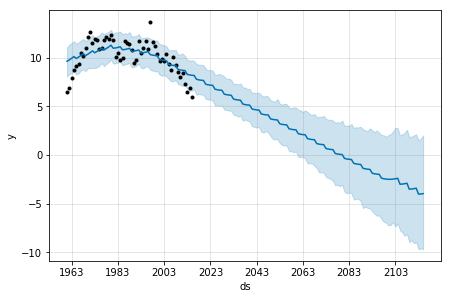

Sweden


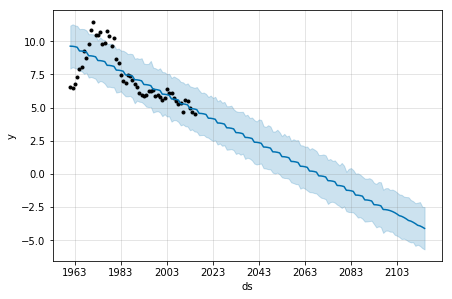

Finland


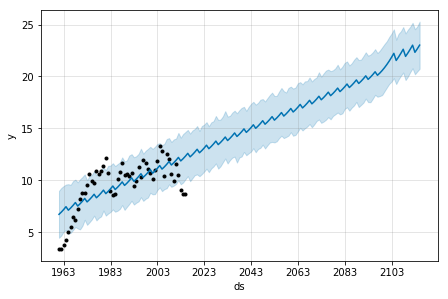

France


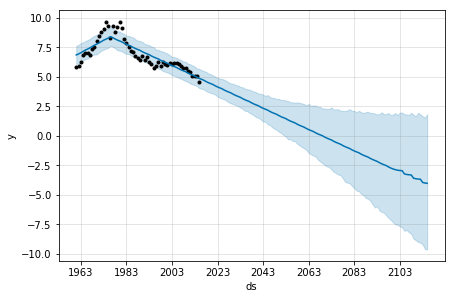

Austria


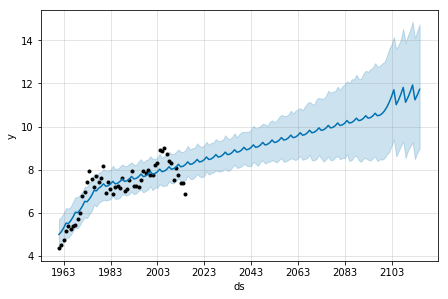

INFO:fbprophet:n_changepoints greater than number of observations.Using 18.


Germany


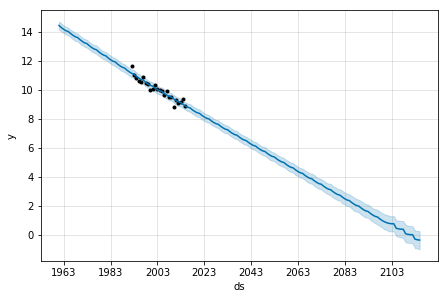

INFO:fbprophet:n_changepoints greater than number of observations.Using 17.


Czech Republic


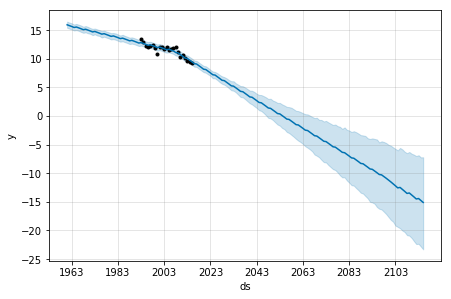

Norway


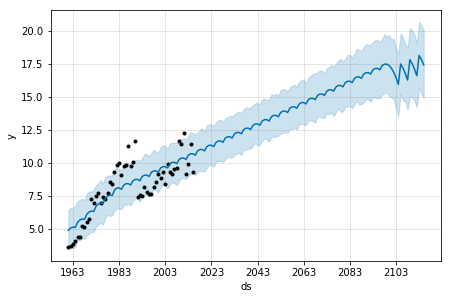

Netherlands


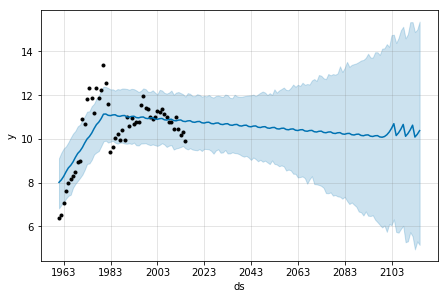

INFO:fbprophet:n_changepoints greater than number of observations.Using 17.


Estonia


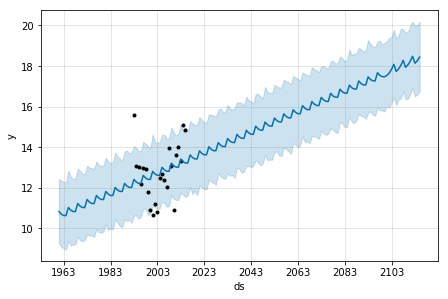

In [7]:
def run_prophet(e):
    t_prophet = pd.DataFrame()
    t_prophet['ds'] = e.index
    t_prophet['y'] = e['emissions'].values

    m = Prophet(weekly_seasonality=False, daily_seasonality=False)
    m.fit(t_prophet)

    future = m.make_future_dataframe(freq='y', periods=100)
    forecast = m.predict(future)

    return m, forecast

for df in dfs:
    print(df['country'])
    m, forecast = run_prophet(df['df'])
    fig = m.plot(forecast);
    fig.set_size_inches(6,4)
    plt.show(fig)